**Imports**

In [1]:
import copy
import itertools as it
import math

import simple_reactions_lib.core.core_classes as coreHelp
import simple_reactions_lib.core.core_units as unitHelp

import simple_reactions_lib.standard.drive_reactions as reactDriver
import simple_reactions_lib.standard.mg_reactions as mgReactHelp


**Configuration variables**

In [2]:

STEP_SIZE = 1
STEPS_PER_GRADIENT_CHECK = 5000
GRADIENT_TOLERANCE = 1e-7 / STEP_SIZE 

#Barriers and prefactors etc
TAFEL_BARRIER = 1.04
TAFEL_PREFACTOR = 1e14

VOLMER_BARRIER = 1.06
VOLMER_PREFACTOR = 1e13

CATH_DESORP_BARRIER = 1.9
CATH_DESSORP_PREFACTOR = 1e13
CATH_SYM_FACTOR = 0.5
CATH_U0 = -0.83

OH_ASSIST_DISSOL_BARRIER = 1.51
OH_ASSIST_DISSOL_PREFACTOR = 1e13
OH_ASSIST_DISSOL_SYM_FACTOR = 0.5
OH_ASSIST_DISSOL_U0 = -2.38

#General reaction conditions
PH = 11
# PH = 7
TEMPERATURE = 298
POTENTIAL = -1.4 
MG_2PLUS_CONC = 2e-5 #This is a molar concentration; used in Nernst equation only

#The varying potentials we will run this at
#POTENTIALS = [-1.4,-1.8, -2.0, -2.2, -2.4, -2.6] #Should be relative to NHE

POTENTIALS = [0.1*x for x in range(-26,-14)]


**Setup the starting reactants**

In [3]:
freeMg = coreHelp.ChemSpeciesStd("free"  , 1.0)
hAds   = coreHelp.ChemSpeciesStd("h_ads" , 0.0)
ohAds  = coreHelp.ChemSpeciesStd("oh_ads", 0.0)


fixedMgTwoPlus = coreHelp.ChemSpeciesStd("fixed_mg_2+", MG_2PLUS_CONC)


startReactants = [freeMg, hAds, ohAds, fixedMgTwoPlus]

**Setup all the reactions**

In [4]:
tafelReaction = mgReactHelp.TafelReaction(TAFEL_BARRIER, TAFEL_PREFACTOR)
volmerReaction = mgReactHelp.VolmerReaction(VOLMER_BARRIER, VOLMER_PREFACTOR)
cathDesorptReaction = mgReactHelp.CathodicOHDesorption(CATH_DESORP_BARRIER, CATH_DESSORP_PREFACTOR, CATH_SYM_FACTOR, CATH_U0)
ohAssistDissol = mgReactHelp.OHAssistedDissolution_Taylor2016(OH_ASSIST_DISSOL_BARRIER, OH_ASSIST_DISSOL_PREFACTOR, OH_ASSIST_DISSOL_SYM_FACTOR, OH_ASSIST_DISSOL_U0)



REACTIONS = [tafelReaction, volmerReaction, cathDesorptReaction, ohAssistDissol]


**Create a callback function so we can track something**

In [5]:
def tempCallbackFunct(instance):
    step = instance.step
    if step%5000 == 0:
        freeConc = [x.conc for x in instance.currentReactants if x.name=="free"]
        hAds = [x.conc for x in instance.currentReactants if x.name=="h_ads"]
        ohAds = [x.conc for x in instance.currentReactants if x.name=="oh_ads"]
        total = sum(freeConc + hAds + ohAds)
        args = [step, freeConc, hAds, ohAds, total]
        print("step = {}; [free]={}, [h_ads]={}, [oh_ads]={}, total={}".format(*args) )
        
        

**Create our reaction controller**

In [6]:
args = [ startReactants, REACTIONS, STEP_SIZE ]
kwargs = {"temperature":TEMPERATURE, "pH":PH, "callbackFunct":tempCallbackFunct, "potential":POTENTIAL}
CONTROLLER = coreHelp.ReactionControllerStandard(*args,**kwargs)

**Get the steady state concentrations numerically at multiple potentials**

In [7]:
reactDriver.runControllerUntilSteadyState?

In [8]:
steadySpeciesNames = ["free" , "h_ads", "oh_ads"]


steadyStateConcs = list()
for pot in POTENTIALS:
    CONTROLLER.potential = pot
    reactDriver.runControllerUntilSteadyState(CONTROLLER, steadySpeciesNames, STEPS_PER_GRADIENT_CHECK, GRADIENT_TOLERANCE)
    steadyStateConcs.append( copy.deepcopy(CONTROLLER.currentReactants) )
    CONTROLLER.reset()



step = 0; [free]=[1.0], [h_ads]=[0.0], [oh_ads]=[0.0], total=1.0
step = 5000; [free]=[0.9422083552362732], [h_ads]=[0.05288022429666024], [oh_ads]=[0.004911420467068567], total=1.000000000000002
step = 10000; [free]=[0.9060735965034628], [h_ads]=[0.08939869978698745], [oh_ads]=[0.004527703709551887], total=1.000000000000002
step = 15000; [free]=[0.8853085669824442], [h_ads]=[0.11038037941864604], [oh_ads]=[0.00431105359891636], total=1.0000000000000067
step = 20000; [free]=[0.8746248583018953], [h_ads]=[0.12117440049015736], [oh_ads]=[0.004200741207953436], total=1.000000000000006
step = 25000; [free]=[0.8694399435042747], [h_ads]=[0.12641256211953264], [oh_ads]=[0.004147494376201732], total=1.000000000000009
step = 30000; [free]=[0.8669950314503567], [h_ads]=[0.12888251614746668], [oh_ads]=[0.00412245240218866], total=1.000000000000012
step = 35000; [free]=[0.8658578060300095], [h_ads]=[0.13003137504599535], [oh_ads]=[0.0041108189240102126], total=1.000000000000015
step = 0; [free]=[1

step = 180000; [free]=[0.5005660697431732], [h_ads]=[0.07645852645289607], [oh_ads]=[0.4229754038039035], total=0.9999999999999728
step = 185000; [free]=[0.4993035774667844], [h_ads]=[0.07622030734220184], [oh_ads]=[0.4244761151909839], total=0.99999999999997
step = 190000; [free]=[0.4981396309962256], [h_ads]=[0.07600043345756069], [oh_ads]=[0.4258599355461824], total=0.9999999999999687
step = 195000; [free]=[0.4970663919356668], [h_ads]=[0.07579747939176526], [oh_ads]=[0.4271361286725384], total=0.9999999999999705
step = 200000; [free]=[0.49607666665132333], [h_ads]=[0.07561013261660723], [oh_ads]=[0.4283132007320418], total=0.9999999999999724
step = 205000; [free]=[0.49516385016781816], [h_ads]=[0.07543718418327157], [oh_ads]=[0.429398965648881], total=0.9999999999999708
step = 210000; [free]=[0.4943218753800714], [h_ads]=[0.07527752024961525], [oh_ads]=[0.4304006043702839], total=0.9999999999999705
step = 215000; [free]=[0.4935451670175786], [h_ads]=[0.07513011435095625], [oh_ads]=

step = 245000; [free]=[0.318029853440245], [h_ads]=[0.04998110955604544], [oh_ads]=[0.6319890370037008], total=0.9999999999999912
step = 250000; [free]=[0.3153846490596827], [h_ads]=[0.04953222453066677], [oh_ads]=[0.6350831264096415], total=0.9999999999999909
step = 255000; [free]=[0.3128343504637806], [h_ads]=[0.04909904716181813], [oh_ads]=[0.6380666023743907], total=0.9999999999999895
step = 260000; [free]=[0.3103749054344272], [h_ads]=[0.04868092037946062], [oh_ads]=[0.6409441741861006], total=0.9999999999999885
step = 265000; [free]=[0.30800247499842537], [h_ads]=[0.04827722141704462], [oh_ads]=[0.6437203035845197], total=0.9999999999999897
step = 270000; [free]=[0.3057134196711692], [h_ads]=[0.04788735959464535], [oh_ads]=[0.6463992207341701], total=0.9999999999999847
step = 275000; [free]=[0.3035042867559719], [h_ads]=[0.04751077427276449], [oh_ads]=[0.6489849389712449], total=0.9999999999999813
step = 280000; [free]=[0.30137179860555285], [h_ads]=[0.047146932961670995], [oh_ad

step = 25000; [free]=[0.6976395886029534], [h_ads]=[0.10578641443161481], [oh_ads]=[0.19657399696542896], total=0.9999999999999972
step = 30000; [free]=[0.6710654717050825], [h_ads]=[0.10481217684461501], [oh_ads]=[0.22412235145029832], total=0.9999999999999958
step = 35000; [free]=[0.6476066935563523], [h_ads]=[0.10272304531614421], [oh_ads]=[0.24967026112750035], total=0.9999999999999968
step = 40000; [free]=[0.626340644630025], [h_ads]=[0.1001703529842788], [oh_ads]=[0.27348900238569324], total=0.9999999999999971
step = 45000; [free]=[0.6067516762447586], [h_ads]=[0.09747027442989802], [oh_ads]=[0.29577804932534496], total=1.0000000000000016
step = 50000; [free]=[0.5885315377961896], [h_ads]=[0.09477396333065881], [oh_ads]=[0.31669449887314827], total=0.9999999999999967
step = 55000; [free]=[0.571480272066094], [h_ads]=[0.09215160589335587], [oh_ads]=[0.33636812204054733], total=0.9999999999999972
step = 60000; [free]=[0.5554569340726517], [h_ads]=[0.08963355932421212], [oh_ads]=[0.

step = 350000; [free]=[0.22222729105477856], [h_ads]=[0.03555280711775634], [oh_ads]=[0.7422199018274477], total=0.9999999999999826
step = 355000; [free]=[0.2201954542835433], [h_ads]=[0.03521939105732293], [oh_ads]=[0.7445851546591155], total=0.9999999999999817
step = 360000; [free]=[0.21821010798699245], [h_ads]=[0.03489351116211079], [oh_ads]=[0.7468963808508834], total=0.9999999999999867
step = 365000; [free]=[0.21626979541659205], [h_ads]=[0.03457493204135899], [oh_ads]=[0.7491552725420348], total=0.9999999999999859
step = 370000; [free]=[0.21437311960488747], [h_ads]=[0.034263427966902835], [oh_ads]=[0.7513634524281965], total=0.9999999999999868
step = 375000; [free]=[0.2125187403274155], [h_ads]=[0.03395878238197044], [oh_ads]=[0.7535224772906004], total=0.9999999999999863
step = 380000; [free]=[0.21070537124808827], [h_ads]=[0.03366078743963668], [oh_ads]=[0.7556338413122641], total=0.999999999999989
step = 385000; [free]=[0.20893177723524106], [h_ads]=[0.03336924356887539], [o

step = 675000; [free]=[0.14811513810726812], [h_ads]=[0.02329607854124212], [oh_ads]=[0.8285887833514914], total=1.0000000000000018
step = 680000; [free]=[0.1475146356953231], [h_ads]=[0.023195515524239263], [oh_ads]=[0.8292898487804381], total=1.0000000000000004
step = 685000; [free]=[0.14692349781480255], [h_ads]=[0.023096489333252597], [oh_ads]=[0.8299800128519437], total=0.9999999999999988
step = 690000; [free]=[0.14634154311644587], [h_ads]=[0.022998970616651043], [oh_ads]=[0.8306594862669012], total=0.9999999999999981
step = 695000; [free]=[0.14576859470924686], [h_ads]=[0.02290293074167446], [oh_ads]=[0.8313284745490764], total=0.9999999999999978
step = 700000; [free]=[0.14520448002443284], [h_ads]=[0.022808341772468318], [oh_ads]=[0.8319871782030948], total=0.9999999999999959
step = 705000; [free]=[0.14464903068440932], [h_ads]=[0.02271517644892253], [oh_ads]=[0.832635792866661], total=0.9999999999999929
step = 710000; [free]=[0.14410208237646038], [h_ads]=[0.022623408166276875

step = 205000; [free]=[0.3103366454797613], [h_ads]=[0.049977358640975765], [oh_ads]=[0.6396859958792711], total=1.0000000000000082
step = 210000; [free]=[0.3058483097029339], [h_ads]=[0.04924694007683741], [oh_ads]=[0.6449047502202377], total=1.000000000000009
step = 215000; [free]=[0.30150041075118333], [h_ads]=[0.0485392384126327], [oh_ads]=[0.6499603508361944], total=1.0000000000000104
step = 220000; [free]=[0.2972866870866126], [h_ads]=[0.04785324146511032], [oh_ads]=[0.6548600714482881], total=1.000000000000011
step = 225000; [free]=[0.29320124341996884], [h_ads]=[0.04718799625888954], [oh_ads]=[0.6596107603211535], total=1.000000000000012
step = 230000; [free]=[0.2892385243108648], [h_ads]=[0.04654260475989867], [oh_ads]=[0.6642188709292535], total=1.0000000000000169
step = 235000; [free]=[0.2853932900194173], [h_ads]=[0.04591621997227648], [oh_ads]=[0.6686904900083204], total=1.0000000000000142
step = 240000; [free]=[0.28166059438834606], [h_ads]=[0.04530804236318214], [oh_ads]

step = 520000; [free]=[0.17029759736003777], [h_ads]=[0.02706419750619197], [oh_ads]=[0.80263820513381], total=1.0000000000000397
step = 525000; [free]=[0.16926196031275267], [h_ads]=[0.02689296503440422], [oh_ads]=[0.803845074652882], total=1.0000000000000389
step = 530000; [free]=[0.16824465249719267], [h_ads]=[0.02672471405190759], [oh_ads]=[0.8050306334509408], total=1.000000000000041
step = 535000; [free]=[0.16724524562011764], [h_ads]=[0.02655937535950458], [oh_ads]=[0.8061953790204192], total=1.0000000000000413
step = 540000; [free]=[0.16626332440262023], [h_ads]=[0.026396881860212214], [oh_ads]=[0.8073397937372081], total=1.0000000000000406
step = 545000; [free]=[0.16529848608896122], [h_ads]=[0.02623716847985766], [oh_ads]=[0.8084643454312226], total=1.0000000000000415
step = 550000; [free]=[0.164350339977509], [h_ads]=[0.026080172091249097], [oh_ads]=[0.8095694879312839], total=1.000000000000042
step = 555000; [free]=[0.1634185069726154], [h_ads]=[0.025925831441732286], [oh_a

step = 35000; [free]=[0.649874115715506], [h_ads]=[0.10294290411173745], [oh_ads]=[0.24718298017276136], total=1.0000000000000049
step = 40000; [free]=[0.6291358704218659], [h_ads]=[0.10045040801384249], [oh_ads]=[0.27041372156429583], total=1.0000000000000042
step = 45000; [free]=[0.6101032744970494], [h_ads]=[0.09781552073199218], [oh_ads]=[0.292081204770964], total=1.0000000000000056
step = 50000; [free]=[0.592464219213581], [h_ads]=[0.09518881613000212], [oh_ads]=[0.31234696465641915], total=1.0000000000000022
step = 55000; [free]=[0.576015523652739], [h_ads]=[0.09263994713674477], [oh_ads]=[0.33134452921051977], total=1.0000000000000036
step = 60000; [free]=[0.56061350586861], [h_ads]=[0.09019879476126687], [oh_ads]=[0.34918769937012983], total=1.0000000000000067
step = 65000; [free]=[0.5461489334263913], [h_ads]=[0.08787568495290544], [oh_ads]=[0.36597538162071336], total=1.00000000000001
step = 70000; [free]=[0.532533948572757], [h_ads]=[0.08567140968367791], [oh_ads]=[0.3817946

step = 350000; [free]=[0.26784587194526316], [h_ads]=[0.0417254932272722], [oh_ads]=[0.690428634827439], total=0.9999999999999744
step = 355000; [free]=[0.26644111625429173], [h_ads]=[0.04148473899625298], [oh_ads]=[0.6920741447494265], total=0.9999999999999712
step = 360000; [free]=[0.2650789144192244], [h_ads]=[0.04125110971230411], [oh_ads]=[0.6936699758684404], total=0.9999999999999689
step = 365000; [free]=[0.2637577903382282], [h_ads]=[0.04102436420499865], [oh_ads]=[0.6952178454567398], total=0.9999999999999667
step = 370000; [free]=[0.26247632924908343], [h_ads]=[0.04080427117131979], [oh_ads]=[0.696719399579564], total=0.9999999999999671
step = 375000; [free]=[0.26123317463143575], [h_ads]=[0.04059060867838247], [oh_ads]=[0.6981762166901481], total=0.9999999999999662
step = 380000; [free]=[0.26002702529576294], [h_ads]=[0.04038316369627152], [oh_ads]=[0.6995898110079336], total=0.999999999999968
step = 385000; [free]=[0.2588566326459837], [h_ads]=[0.04018173165888573], [oh_ads

step = 115000; [free]=[0.5162048436212342], [h_ads]=[0.0801669950169841], [oh_ads]=[0.4036281613617889], total=1.000000000000007
step = 120000; [free]=[0.511922260456705], [h_ads]=[0.07939169046011078], [oh_ads]=[0.4086860490831953], total=1.000000000000011
step = 125000; [free]=[0.507959998103417], [h_ads]=[0.0786725875747905], [oh_ads]=[0.41336741432180746], total=1.0000000000000149
step = 130000; [free]=[0.5042925078887992], [h_ads]=[0.07800540062565454], [oh_ads]=[0.4177020914855648], total=1.0000000000000187
step = 135000; [free]=[0.5008964954559463], [h_ads]=[0.07738620043774366], [oh_ads]=[0.42171730410632824], total=1.0000000000000182
step = 140000; [free]=[0.4977506920110692], [h_ads]=[0.07681138130193009], [oh_ads]=[0.42543792668702063], total=1.00000000000002
step = 145000; [free]=[0.49483565308786354], [h_ads]=[0.07627763105059615], [oh_ads]=[0.4288867158615596], total=1.000000000000019
step = 150000; [free]=[0.4921335808077476], [h_ads]=[0.07578190414074396], [oh_ads]=[0.4

In [9]:
[str(x) for x in steadyStateConcs[0]]

['ChemSpeciesStd: free conc=0.865',
 'ChemSpeciesStd: h_ads conc=0.131',
 'ChemSpeciesStd: oh_ads conc=0.00411',
 'ChemSpeciesStd: fixed_mg_2+ conc=2e-05']

**Plot the concentrations**

In [10]:
def _getPlotDataFromSteadyStateConcsArray(xVar, concsArray, species):

    allData = list()
    for spec in species:
        currData = list()
        for pot, concs in it.zip_longest(xVar,concsArray):
            currConcs = [x.conc for x in concs if x.name==spec]
            assert len(currConcs)==1
            currData.append( [pot,currConcs[0]] )

        allData.append(currData)
    return allData


In [11]:
concsArray = steadyStateConcs
xVar = POTENTIALS
species = ["free", "h_ads", "oh_ads"]

allData = list()
for spec in species:
    currData = list()
    for pot, concs in it.zip_longest(xVar,concsArray):
        currConcs = [x.conc for x in concs if x.name==spec]
        assert len(currConcs)==1
        currData.append( [pot,currConcs[0]] )
        
    allData.append(currData)



In [12]:
species = ["free", "h_ads", "oh_ads"]
toPlot = _getPlotDataFromSteadyStateConcsArray(POTENTIALS, steadyStateConcs, species)

**Create the plotter**

In [13]:
import gen_basis_helpers.shared.data_plot_base as dPlotHelp
dPlotHelp.DataPlotterStandard().registeredKwargs

{'axHandle',
 'data',
 'dataLabels',
 'fontSizeAll',
 'legend',
 'lineColors',
 'lineMarkerSizes',
 'lineMarkers',
 'lineStyles',
 'mapPlotDataFunct',
 'plotFunct',
 'removeXTicks',
 'removeYTicks',
 'show',
 'showTitle',
 'titleStr',
 'xLim',
 'xTickLabelRotation',
 'xTickLabels',
 'xTickValues',
 'xlabel',
 'yLim',
 'ylabel'}

In [14]:
currKwargs = {"xlabel":"Potential", "ylabel":"Fractional Coverage", "yLim":[0,1],
              "lineMarkers":["x"], "dataLabels":species, "legend":True}

currPlotter = dPlotHelp.DataPlotterStandard(**currKwargs)

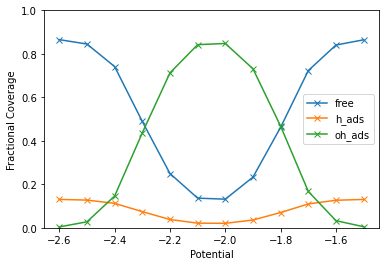

In [15]:
currPlot = currPlotter.createPlot(toPlot)